# σ density plot for 15 randomly shuffled filters

To test the robustness of the filter order, the set of filters is randomly shuffled, creating a new, randomized sequence. This shuffled sequence is then used to train a new set of SOMs in the same manner as before. In this case, SOMs are trained incrementally: the first SOM uses only the first filter from the shuffled sequence, the second SOM uses the first two filters, and so on, until all filters in the shuffled order are included. This allows for an evaluation of whether the order of filters affects the convergence of photo-z standard deviation (σₚₑₐₖ), providing insights into the influence of filter arrangement on the results.The figure below illustrates the filter order:  
![Filters Sorted Randomly](table_filters_random.jpg)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer modern"],  # You can change the serif font here if needed
    "axes.labelsize": 14,     # Adjust as needed
    "axes.linewidth": 0.5,    # Adjust line width if necessary
    "xtick.labelsize": 12,    # Adjust tick label size
    "ytick.labelsize": 12,    
    "legend.fontsize": 12,    
    "legend.handlelength": 2.0
})

/tmp/ipykernel_19928/3303862502.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', a)


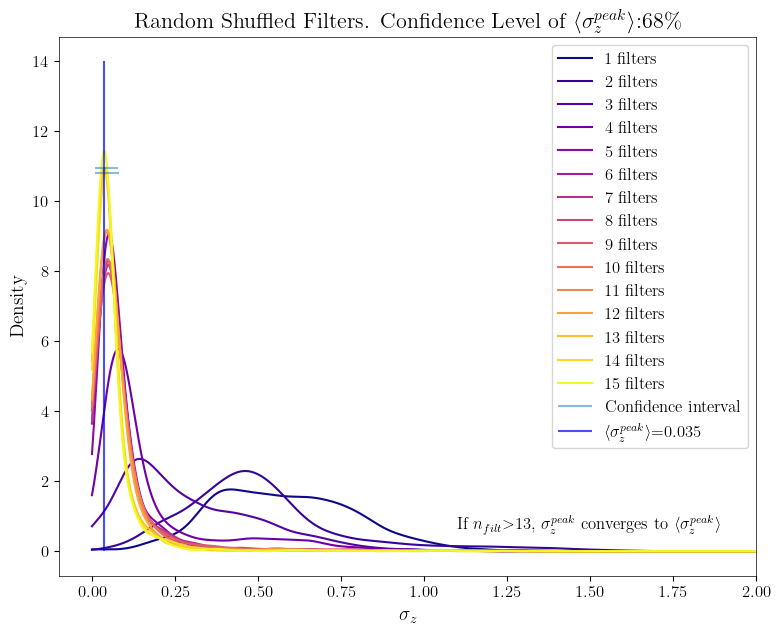

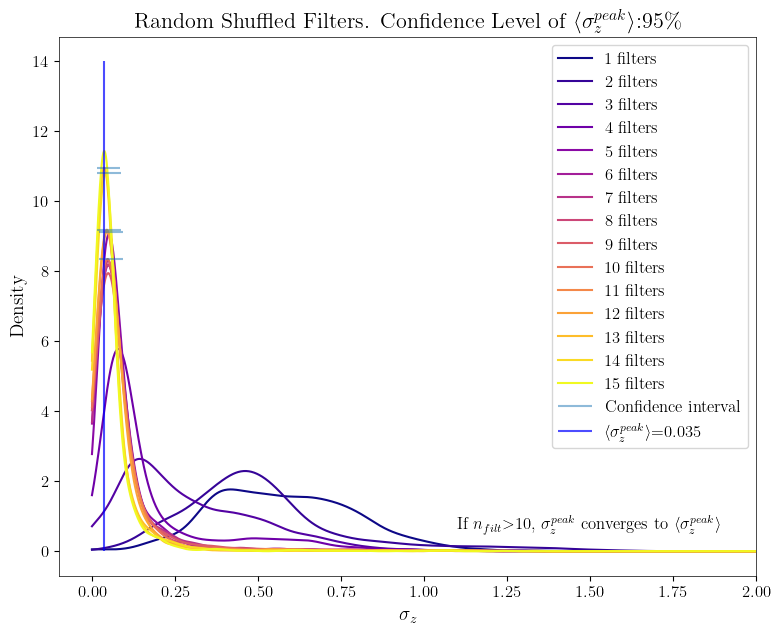

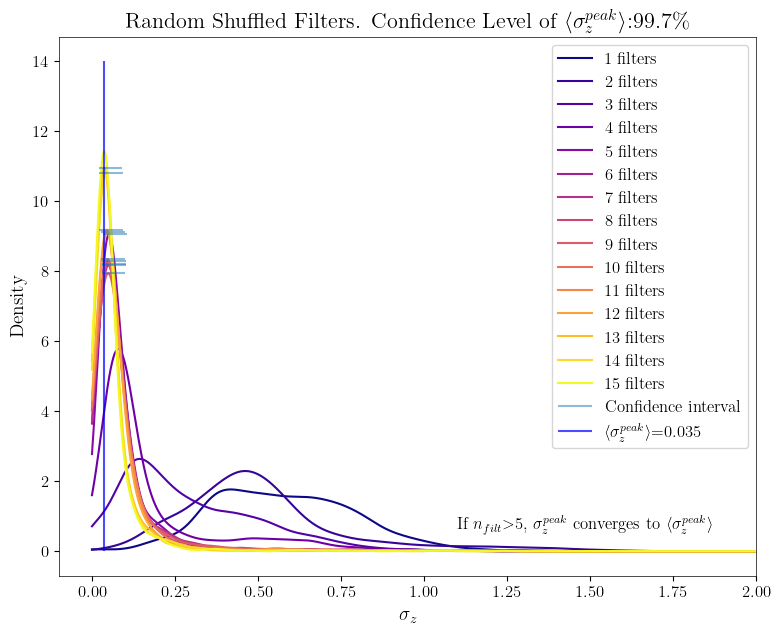

In [6]:

file_template = '/home/nina/IFAE/SOM/SOM_prep/many_filters/SOM_Done_lp_griz_ilim_random64_{}_NEW.fits'
somres = 64
filt_use = ['GALEX_FUV', 'GALEX_NUV', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
a = len(filt_use)

hist_data = [[] for _ in range(a)]

cmap = cm.get_cmap('plasma', a)
colors = [cmap(i) for i in range(a)]

maximum = []

k=[1,2,3]
conf=[68,95,99.7]
    
for l in k:
    plt.figure(figsize=(9,7))
    
    for filt_index in range(a):
        sigma = []
        z_cells = [[] for _ in range(somres ** 2)]
        file_path = file_template.format(filt_index)
    
        try:
            data = Table.read(file_path)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue
    
        b = len(data)
        z_values = data['photoz']
        cell_classifications = data['cell'].data
    
        for k in range(b):
            cell_index = cell_classifications[k]
            z = z_values[k]
            z_cells[cell_index].append(z)
    
        for z in z_cells:
            if z:
                sigma.append(np.std(z))
    
        if sigma:
            kde = gaussian_kde(sigma, bw_method='scott')
            x_grid = np.linspace(min(sigma), 2, 1000)
            kde_values = kde(x_grid)
            maximum.append((max(kde_values), filt_index))
            plt.plot(x_grid, kde_values, color=colors[filt_index], label=str(filt_index + 1) + ' filters')
            
            # Find the x value at the peak of the KDE
            max_kde_value = max(kde_values)
            max_index = np.where(kde_values == max_kde_value)[0][0]
            sigma_at_max_kde = x_grid[max_index]
            closest_sigma = min(sigma, key=lambda x: abs(x - sigma_at_max_kde))
            
            hist_data[filt_index] = (closest_sigma, filt_index)
    
    
    hist_data.reverse()
    

    
    lower_bound=0.035486165864797664-l*0.005818806067624589 #this is the avrage of the sigma_peak found when the filters were ordered. 
    upper_bound=0.035486165864797664+l*0.005818806067624589
    maximum.reverse()
        
    for i in range(1,a):
        arr=np.array([hist_data[i][0],hist_data[i-1][0]])
        avrg=np.mean(arr)
        if lower_bound <= hist_data[i][0] <= upper_bound:
            if i==1:
                plt.hlines(maximum[i][0],avrg-lower_bound,avrg+upper_bound, alpha=0.5, label='Confidence interval')
            else:
                plt.hlines(maximum[i][0],avrg-lower_bound,avrg+upper_bound, alpha=0.5)
        else:
            th=a-i
            break
 
            
     
    plt.xlabel(r'$\sigma_{z}$')
    plt.ylabel('Density')
    plt.xlim(-0.1,2)
    #plt.vlines(lower_bound,0,14,alpha=0.1)
    #plt.vlines(upper_bound,0,14,alpha=0.1)
    plt.vlines(0.035486165864797664, 0, 14, color='blue', alpha=0.7, label=r'$\langle\sigma_{z}^{peak}\rangle$=0.035')

    plt.title(r'Random Shuffled Filters. Confidence Level of ' +r'$\langle\sigma_{z}^{peak}\rangle$'  + ':'+str(conf[l-1])+r'$\%$', size=16)

    plt.text(1.1,0.6,'If '+ r'$n_{filt}$'+r'$>$' +str(th+1)+', '+ r'$\sigma_{z}^{peak}$ converges to '+ r'$\langle\sigma_{z}^{peak}\rangle$', size=12)
    plt.legend()
    #plt.savefig("%02.d"%l+'.png', bbox_inches='tight', dpi=300)
    plt.show()
   

